<div style="text-align: center;">
  <h1>T-N mismatch clustering tutorial</h1>
</div>
   

In [37]:
#Load libraries

import pandas as pd
import numpy as np
from nilearn import plotting
import nibabel as nib
import os
import mismatch
from mismatch.TNMismatchClustering import TNMismatchClustering
from mismatch.MTLSuperPoints import create_MTLSuperPoints


# 1. T-N Mismatch Clustering

Based on our prior work, T-N mismatch reveals patterns of vulnerability and resilience that may be driven by non-AD factors in patients with Alzheimer's disease.

The figure below illustrates the overall flow of the T-N mismatch clustering approach:

![T-N mismatch clustering workflow](figures/mismtach_clustering.png)








#### 
### 1.1 Prepare the Input CSV for T-N Mismatch Clustering

The input CSV should include columns for regional Tau and cortical thickness measurements in either of the following formats:

- `{LabelID}_tau`, `{LabelID}_thickness`  
  *e.g.*, `31_tau`, `31_thickness`

- `{ROIName}_tau`, `{ROIName}_thickness`  
  *e.g.*, `Right.Amygdala_tau`, `Right.Amygdala_thickness`

**Both formats are supported** and can be used interchangeably.

If residual modeling requires additional adjustments, the CSV should also include relevant **covariate columns** such as:

- `age`, `sex`, `**_amy`, etc.

Make sure all required values are present and properly aligned for each subject.


In [38]:
input_csv = "./simulated_data/simulated_DKT_TN_data_with_cov.csv"
pd.read_csv(input_csv).head(5)



,ID,1002_tau,1002_thickness,1003_tau,1003_thickness,1005_tau,1005_thickness,1006_tau,1006_thickness,1007_tau,...,1002_amyloid,1003_amyloid,1013_amyloid,1014_amyloid,1015_amyloid,1016_amyloid,2035_amyloid,age,sex,gender
0,sub-000,1.623620,1.051461,2.335559,2.518862,0.866115,3.423962,1.666032,2.930612,3.089310,...,1.737246,1.593075,0.515366,1.734063,1.824727,1.942790,0.571814,66,0,Male
1,sub-001,3.352143,3.424775,0.918482,1.426310,1.985531,2.937832,1.314047,1.496789,2.369894,...,1.553194,0.963045,0.925246,1.157351,0.421324,0.361954,1.631894,82,0,Female
2,sub-002,2.695982,3.081107,1.376434,1.162629,0.603166,3.348747,2.986213,1.013805,1.492694,...,1.541844,0.234616,1.736545,0.877231,1.245933,1.708770,1.722740,71,1,Male
3,sub-003,2.295975,1.530848,1.599086,3.372214,3.227961,3.237068,1.570260,3.038654,0.690675,...,1.689566,0.250372,1.454338,1.450515,1.263120,0.984556,1.693029,70,1,Male
4,sub-004,0.968056,1.454562,1.868210,3.414080,1.276340,2.494750,1.342804,2.767143,1.432947,...,1.522048,1.371131,1.485413,0.973338,1.466226,0.494462,1.837853,81,0,Male


### 1.2 Run T-N Mismatch Modeling

This section demonstrates how to run T-N mismatch modeling using different input types.

---

### 1.2 Example A. T-N Mismatch Modeling Using the Predefined DKT Atlas

You can use one of the predefined atlases provided by the pipeline:

- **DKT Atlas**  
- **BrainCOLOR Atlas**

These atlases come with built-in label maps, allowing for region-based residual modeling and the generation of residual NIfTI maps.

---

####  Optional: Define Feature Weights

Users can optionally define custom weights for each feature (e.g., to upweight or downweight specific regions).  
If no weights are provided, all features are treated equally by default.

If you do not wish to use feature weights, simply omit the `feature_weights=feature_weights` argument when calling the pipeline function.

---

**Note:**  
More detailed information about each parameter can be found in the `README.md` file.


In [39]:
pipeline = TNMismatchClustering(atlas="DKT")
feature_weights = {
    "1002": 0.001,
    "1007": np.sqrt(7)
} # Users can defined the weights for each feature if needed. 

results = pipeline.run_pipeline(
    input_csv="./simulated_data/simulated_DKT_TN_data_with_cov.csv",
    independent="tau",
    predict="thickness",
    output_prefix="results/output",
    sd_thresh=1, # Users can define the threshold for binarization. If sd_thresh=0, then using pure residual without binarization
    log_transform=True,
    covariates=["age", "*amyloid"], # "amyloid" is ROI specific covariaes, and "age" is a global covariate for all ROIs
    feature_weights=feature_weights
) #In this example, we did not choose the number of clusters so the algorithm will choose the optimal number automatically 



                               🌟 Welcome to the Mismatch Universe! 🌟                                
             🧠 PATCH Lab warmly welcomes you to explore brain heterogenity together!! 😊             
🗺️  Using predefined atlas: DKT
👤 Number of subjects: 50
🧠 Number of ROIs: 62

 Pearson correlation summary between independent and dependent variables:
  - 30 out of 62 ROIs show significant correlation (p < 0.05)
  - 6 out of 62 ROIs show a trend (0.05 < p < 0.1)
📈 Running robust bisquare regression...
    - Global covariates used: age
    - ROI-specific covariate used in 7 out of 62 ROIs: amyloid
📊 Using residuals for clustering (SD=1)...
🔗 Running Ward.D2 clustering...

🔎 Auto-selecting number of clusters based on elbow method...
📐 Optimal number of clusters estimated: 6

📊 Cluster Membership Counts:
  Cluster 1: 5 subjects
  Cluster 2: 15 subjects
  Cluster 3: 5 subjects
  Cluster 4: 7 subjects
  Cluster 5: 6 subjects
  Cluster 6: 12 subjects
🖼️ Residual heatmap saved for Cluster 1 

### 1.2 Example B. T-N Mismatch Modeling on Imaging or Non-Imaging Data

This approach does **not** require an atlas definition. It is suitable for both imaging and non-imaging datasets.

 **Key Notes:**
- It outputs a **residual heatmap**, but **not** a residual NIfTI map.
- This makes it applicable to any dataset where region-wise or feature-wise modeling is possible.
- Just ensure that the independent and predicted variable names follow a matching convention, such as:

  - `RegionX_A`, `RegionX_B`
  - or `FeatureY_A`, `FeatureY_B`

 The suffixes (e.g., `_A`, `_B`) must be consistent across all features to ensure correct pairing during mismatch modeling.
 
 Below is an example still using imaging derived feature, but can be generalizable to other non-imaging biomarkers.


In [16]:
# explore using no atlas at all. could be non-imaging data. 
from mismatch.TNMismatchClustering import TNMismatchClustering

clust = TNMismatchClustering()

# Run full pipeline
outputs = clust.run_pipeline(
    input_csv="./simulated_data/simulated_data_BrainCOLOR_ROI_names.csv",
    independent="tau",
    predict="thickness",
    n_clusters=6,
    output_prefix="results/demo_run",
    log_transform=True,
    generate_maps=True  
)

                               🌟 Welcome to the Mismatch Universe! 🌟                                
             🧠 PATCH Lab warmly welcomes you to explore brain heterogenity together!! 😊             
🗺️  Using predefined atlas: None
👤 Number of subjects: 200
🧠 Number of ROIs: 100

 Pearson correlation summary between independent and dependent variables:
  - 12 out of 100 ROIs show significant correlation (p < 0.05)
  - 5 out of 100 ROIs show a trend (0.05 < p < 0.1)
   ⚠️ Caution: Looks like the correlation between your variables is on the low side.
     Keep in mind - Mismatch modeling works best when there's at least some relationship!
📈 Running robust bisquare regression...
📊 Using residuals for clustering (SD=1.5)...
🔗 Running Ward.D2 clustering...

📊 Cluster Membership Counts:
  Cluster 1: 33 subjects
  Cluster 2: 12 subjects
  Cluster 3: 110 subjects
  Cluster 4: 5 subjects
  Cluster 5: 21 subjects
  Cluster 6: 19 subjects
🖼️ Residual heatmap saved for Cluster 1 at: results/dem

### 1.2 Example C. Explore T-N Mismatch Using a Customized Atlas

You can use your own customized atlas and region labels for T-N mismatch modeling.

 **Requirements:**
- Provide a segmentation image (NIfTI format) for `custom_atlas_path`.
- Provide a label description CSV via `custom_label_csv`.

The `custom_label_csv` must include the following columns:
- `index`: the integer label ID corresponding to regions in the atlas.
- `name`: the region name associated with label ID.

 

In [40]:
custom_label_csv = "./simulated_data/custom_labels.csv"
pd.read_csv(custom_label_csv).head(10)


,index,name
0,4,3rd.Ventricle
1,11,4th.Ventricle
2,23,Right.Accumbens.Area
3,30,Left.Accumbens.Area
4,31,Right.Amygdala
5,32,Left.Amygdala
6,35,Brain.Stem
7,36,Right.Caudate
8,37,Left.Caudate
9,38,Right.Cerebellum.Exterior


In this example, we used `simulated_data_BrainCOLOR_ROI_names.csv`, where column names correspond to region names (e.g., `Right.Amygdala_tau`, `Left.Hippocampus_thickness`).

Alternatively, using label IDs as column names (e.g., `31_tau`, `48_thickness`), as in `simulated_data_BrainCOLOR_label_names.csv`, also works.

Just make sure that the region names or label IDs in your input CSV **match the `name` or `index` values** defined in your `custom_label_csv`.


In [41]:
# Show input csv

input_csv = "./simulated_data/simulated_data_BrainCOLOR_ROI_names.csv"
pd.read_csv(input_csv).head(5)


,ID,Right.Amygdala_tau,Right.Amygdala_amy,Right.Amygdala_thickness,Left.Amygdala_tau,Left.Amygdala_amy,Left.Amygdala_thickness,Right.Hippocampus_tau,Right.Hippocampus_amy,Right.Hippocampus_thickness,...,Left_TrIFG_triangular_part_of_the_inferior_frontal_gyrus_tau,Left_TrIFG_triangular_part_of_the_inferior_frontal_gyrus_amy,Left_TrIFG_triangular_part_of_the_inferior_frontal_gyrus_thickness,Right.TTG.transverse.temporal.gyrus_tau,Right.TTG.transverse.temporal.gyrus_amy,Right.TTG.transverse.temporal.gyrus_thickness,Left.TTG.transverse.temporal.gyrus_tau,Left.TTG.transverse.temporal.gyrus_amy,Left.TTG.transverse.temporal.gyrus_thickness,age
0,sub1,1.856711,1.076951,3.772909,1.365365,1.173686,5.241552,1.407910,1.165973,2.729908,...,0.911034,1.575342,1.862777,0.853633,1.468738,0.649752,0.932933,1.215115,0.675888,76
1,sub2,1.297409,1.012583,6.004230,1.258188,0.893221,3.518526,1.429636,1.072555,2.151218,...,1.321123,1.211633,1.528025,1.204989,1.294520,0.844164,1.136054,1.346449,0.885206,78
2,sub3,1.565502,1.049160,4.674890,1.533949,1.086714,4.006725,1.268937,1.010938,1.966648,...,1.111955,1.410140,1.492789,0.771212,1.285403,1.069547,0.770142,1.545456,1.025945,81
3,sub4,1.643440,1.087034,4.542671,1.126800,1.000415,4.795834,1.548982,1.191500,2.286685,...,1.421623,1.143557,1.791495,1.104850,1.264021,0.938199,1.498301,1.278227,0.680537,84
4,sub5,1.577389,1.078615,4.942140,1.790563,1.185197,2.955959,1.592989,1.085119,2.449806,...,0.923318,1.263589,1.489767,0.627132,1.099354,0.757513,1.098847,1.178864,1.083735,81


In [42]:
# explore using customized atlas

# Initialize with custom atlas + label CSV
clust = TNMismatchClustering(
    custom_atlas_path="./simulated_data/antsMalfLabeling.nii.gz", #Input your customized atlas
    custom_label_csv="./simulated_data/custom_labels.csv" #Input your customized atlas dictionary 
)

# Run full pipeline
outputs = clust.run_pipeline(
    input_csv="./simulated_data/simulated_data_BrainCOLOR_ROI_names.csv", # Both simulated_data_BrainCOLOR_ROI_names.csv or simulated_data_BrainCOLOR_label_names.csv would work
    independent="tau",
    predict="thickness",
    sd_thresh=1.5,
    n_clusters=6,
    output_prefix="results/demo_run1",
    log_transform=True,
    generate_maps=True  
)

                               🌟 Welcome to the Mismatch Universe! 🌟                                
             🧠 PATCH Lab warmly welcomes you to explore brain heterogenity together!! 😊             
🗺️  Using predefined atlas: None
👤 Number of subjects: 200
🧠 Number of ROIs: 100

 Pearson correlation summary between independent and dependent variables:
  - 12 out of 100 ROIs show significant correlation (p < 0.05)
  - 5 out of 100 ROIs show a trend (0.05 < p < 0.1)
   ⚠️ Caution: Looks like the correlation between your variables is on the low side.
     Keep in mind - Mismatch modeling works best when there's at least some relationship!
📈 Running robust bisquare regression...
📊 Using residuals for clustering (SD=1.5)...
🔗 Running Ward.D2 clustering...

📊 Cluster Membership Counts:
  Cluster 1: 33 subjects
  Cluster 2: 12 subjects
  Cluster 3: 110 subjects
  Cluster 4: 5 subjects
  Cluster 5: 21 subjects
  Cluster 6: 19 subjects
🖼️ Residual heatmap saved for Cluster 1 at: results/dem

### 1.3 Output Residual Values for Each Individual

The pipeline outputs a residual matrix for each individual across all regions or features.

- **Negative residual** → Neurodegeneration greater than expected given Tau (**N > T**)
- **Positive residual** → Neurodegeneration less than expected given Tau (**N < T**)

These residuals are the basis for mismatch clustering and can also be visualized using heatmaps or projected onto brain maps (if an atlas is used).


In [43]:
# T-N residual value for each subject in the output
outputs["residual_df"].head()


,ID,Right.Amygdala_thickness,Left.Amygdala_thickness,Right.Hippocampus_thickness,Left.Hippocampus_thickness,Right.ACgG.anterior.cingulate.gyrus_thickness,Left.ACgG.anterior.cingulate.gyrus_thickness,Right.AIns.anterior.insula_thickness,Left.AIns.anterior.insula_thickness,Right.AOrG.anterior.orbital.gyrus_thickness,...,Left.SPL.superior.parietal.lobule_thickness,Right.STG.superior.temporal.gyrus_thickness,Left.STG.superior.temporal.gyrus_thickness,Right.TMP.temporal.pole_thickness,Left.TMP.temporal.pole_thickness,Right_TrIFG_triangular_part_of_the_inferior_frontal_gyrus_thickness,Left_TrIFG_triangular_part_of_the_inferior_frontal_gyrus_thickness,Right.TTG.transverse.temporal.gyrus_thickness,Left.TTG.transverse.temporal.gyrus_thickness,T_N_cluster
0,sub1,-0.686426,0.970195,0.417387,0.061059,0.260808,-0.500229,-0.145750,-0.399578,0.406097,...,0.310265,-0.077470,-0.344610,0.715672,-0.082095,0.035422,0.185580,-0.125754,-0.175729,3
1,sub2,1.506732,-0.706742,-0.160094,1.155815,-0.055137,-0.181803,0.523354,0.058440,-0.140204,...,-0.386074,-0.184628,-0.405624,0.343510,0.001163,-0.159480,-0.157145,-0.054620,-0.024820,3
2,sub3,0.197392,-0.330271,-0.354072,0.175731,-0.136103,-0.201689,-0.022828,0.105682,0.329601,...,0.110013,0.137255,0.285639,0.192286,-1.176222,0.116251,-0.188683,0.330352,0.231188,3
3,sub4,0.070346,0.632747,-0.018303,-0.726036,-0.038397,-0.400216,-0.334217,-0.175199,0.497066,...,-0.077587,-0.031307,0.105055,0.195320,0.408352,0.165498,0.104752,0.070442,-0.311556,3
4,sub5,0.465447,-1.468246,0.147028,-0.944455,0.495273,0.256314,-0.180331,0.414251,0.070848,...,0.132716,-0.125425,0.018499,0.479115,0.379619,-0.191169,-0.187718,0.092276,0.183583,3


### 1.3 Output T-N Mismatch Groupings and Global T-N Mismatch Score

The pipeline outputs:
- **T-N mismatch group assignments** based on clustering of regional residual patterns.
- A **Global T-N Mismatch Score** for each individual, calculated as the sum of the flipped-sign residuals across regions (weighted if applicable).

**Interpretation:**
- **Higher scores (more positive)** → Greater vulnerability  
  *Neurodegeneration is greater than expected given Tau burden (N > T)*
- **Lower scores (more negative)** → Greater resilience  
  *Neurodegeneration is less than expected given Tau burden (N < T)*



In [44]:
outputs["final_df"].head()


,ID,T_N_cluster,Global_Mismatch_Score,Cluster_Label
0,sub1,3,-1.215926,Likely Canonical
1,sub2,3,-2.060699,Likely Canonical
2,sub3,3,-1.922822,Likely Canonical
3,sub4,3,-5.417493,Likely Canonical
4,sub5,3,-4.768357,Likely Canonical


### 1.3 Output dendrogram

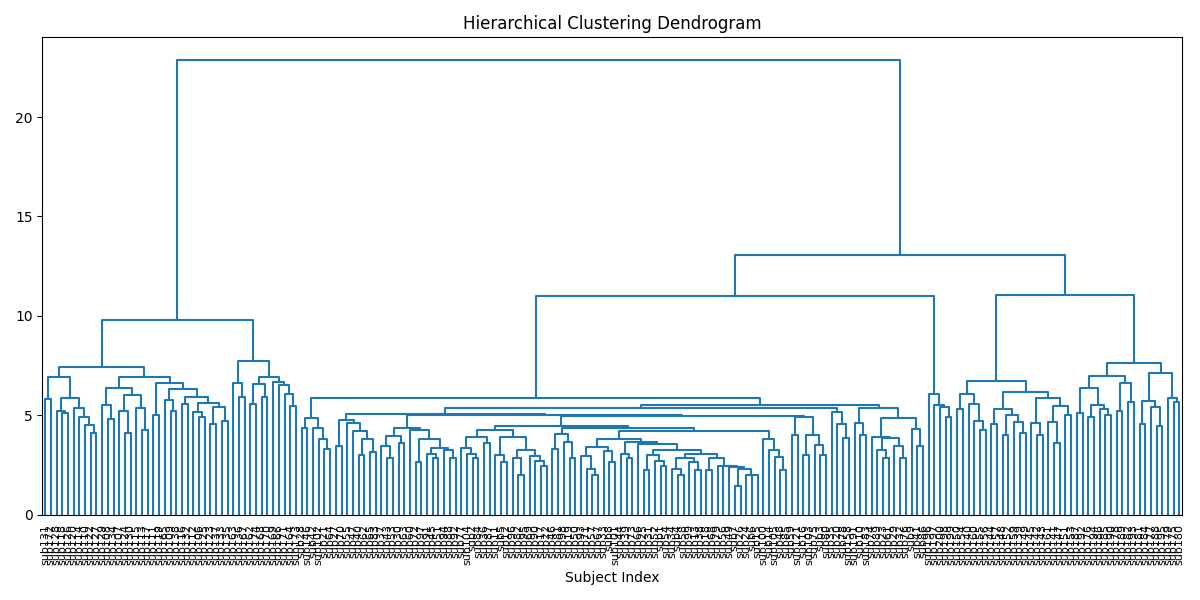

In [45]:
# Dendrogram of the clustering

from IPython.display import Image, display
display(Image(filename="results/demo_run1_dendrogram.png"))

### 1.3 Output residual heatmap for each cluster

Showing Cluster 1 Heatmap:


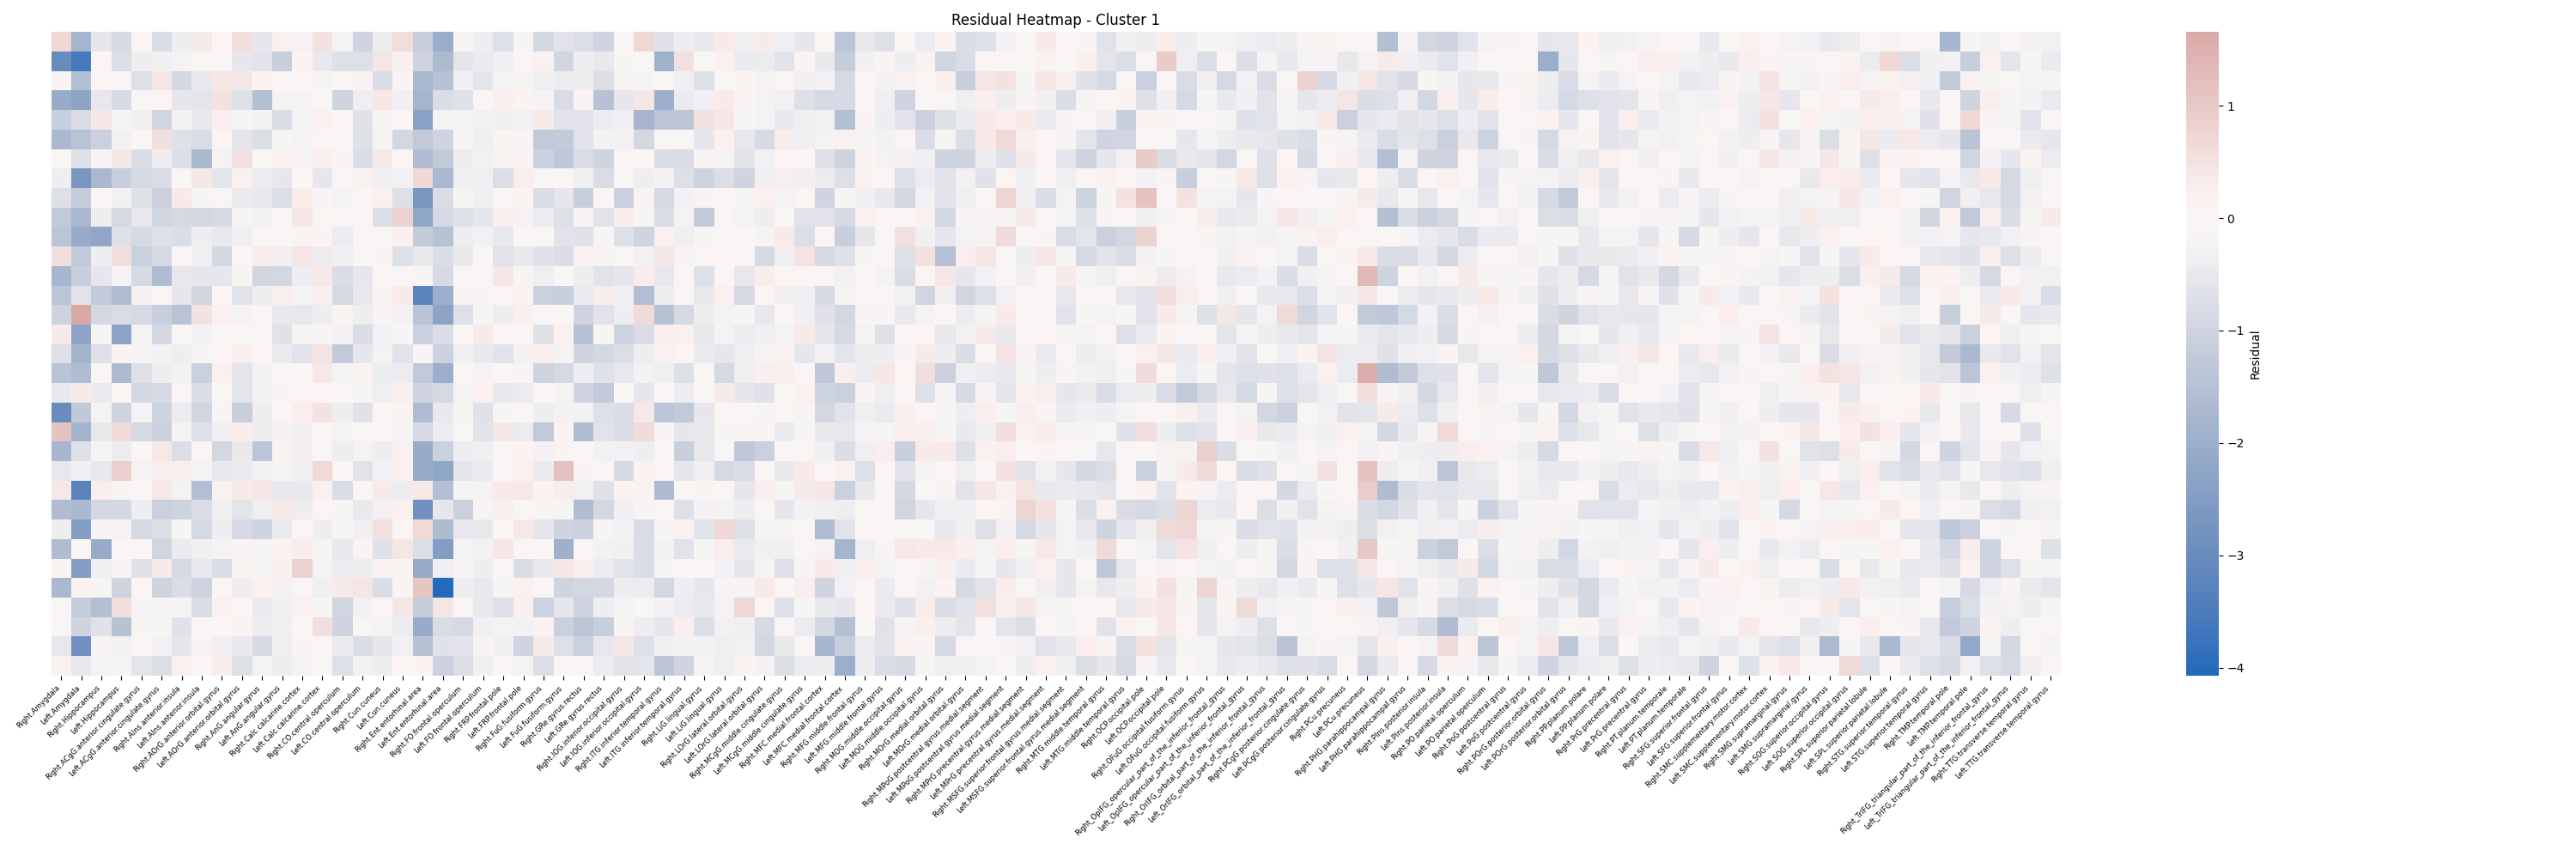

Showing Cluster 2 Heatmap:


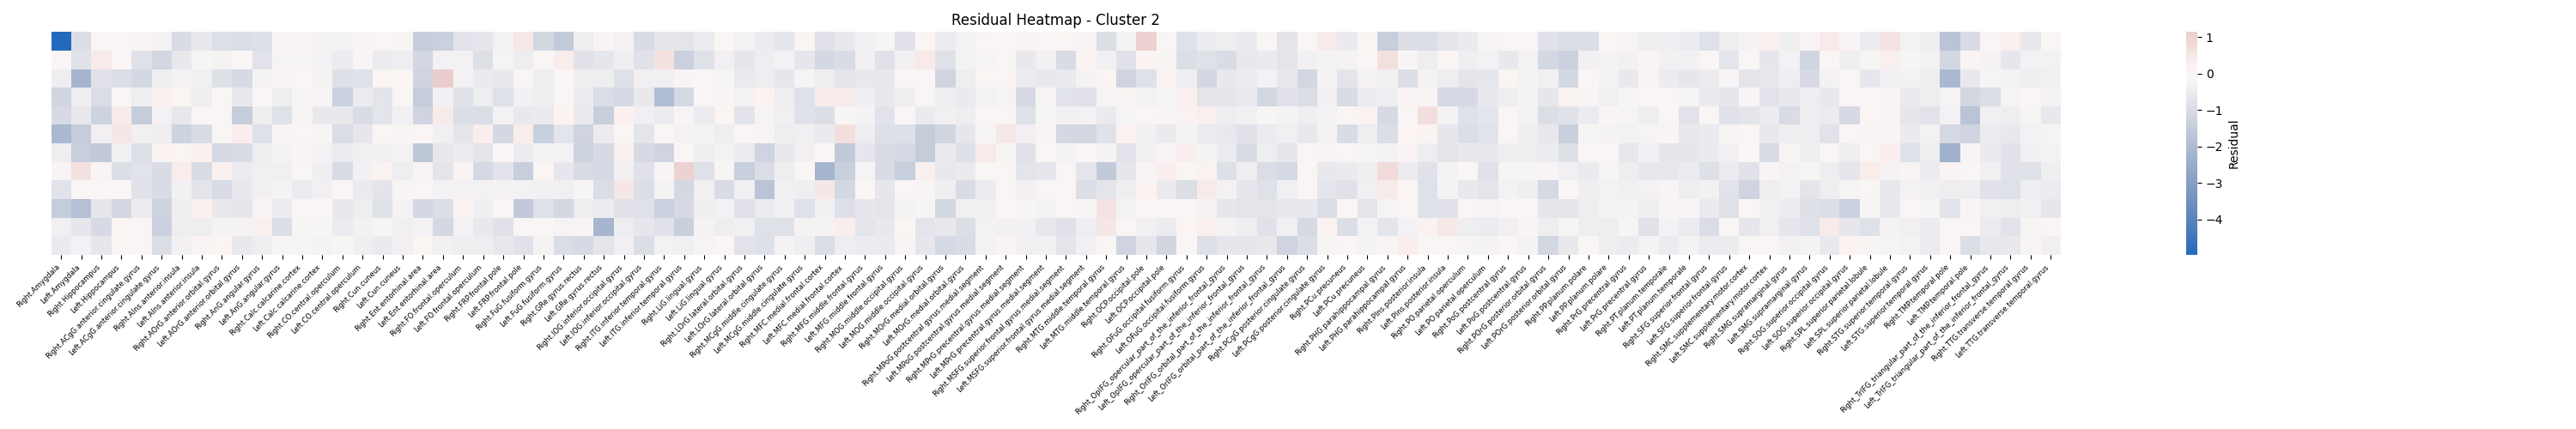

Showing Cluster 3 Heatmap:


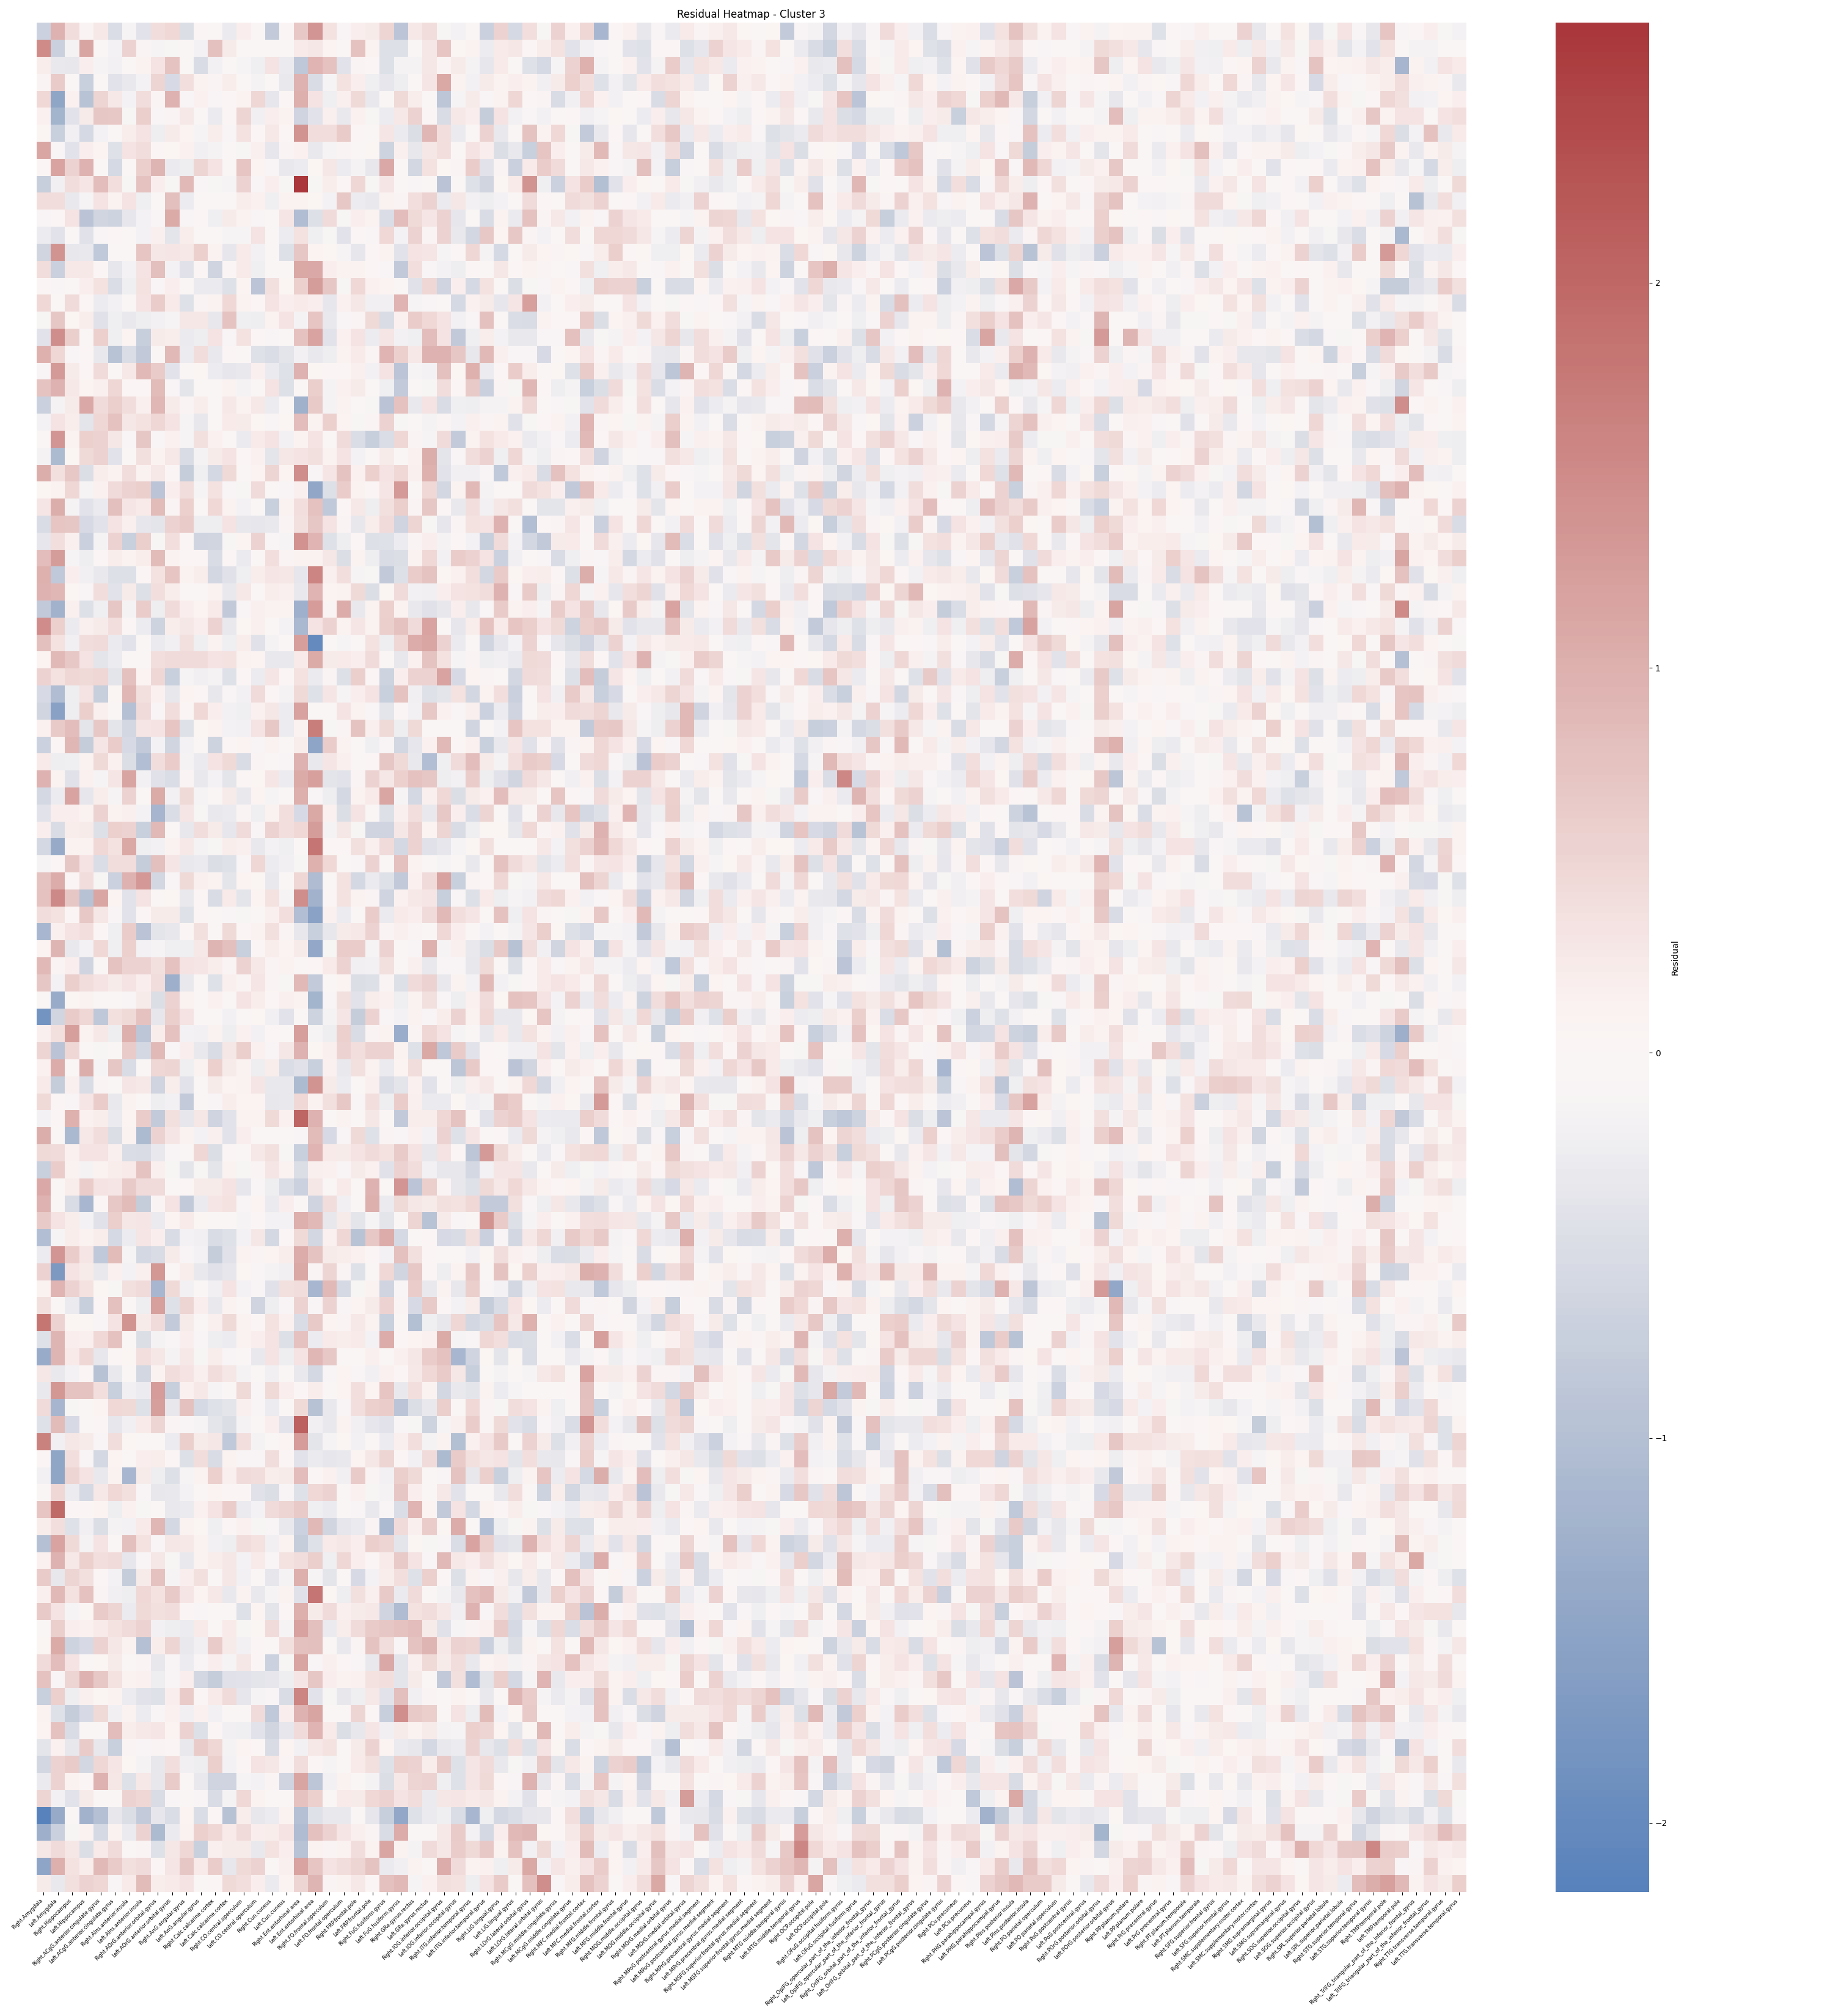

Showing Cluster 4 Heatmap:


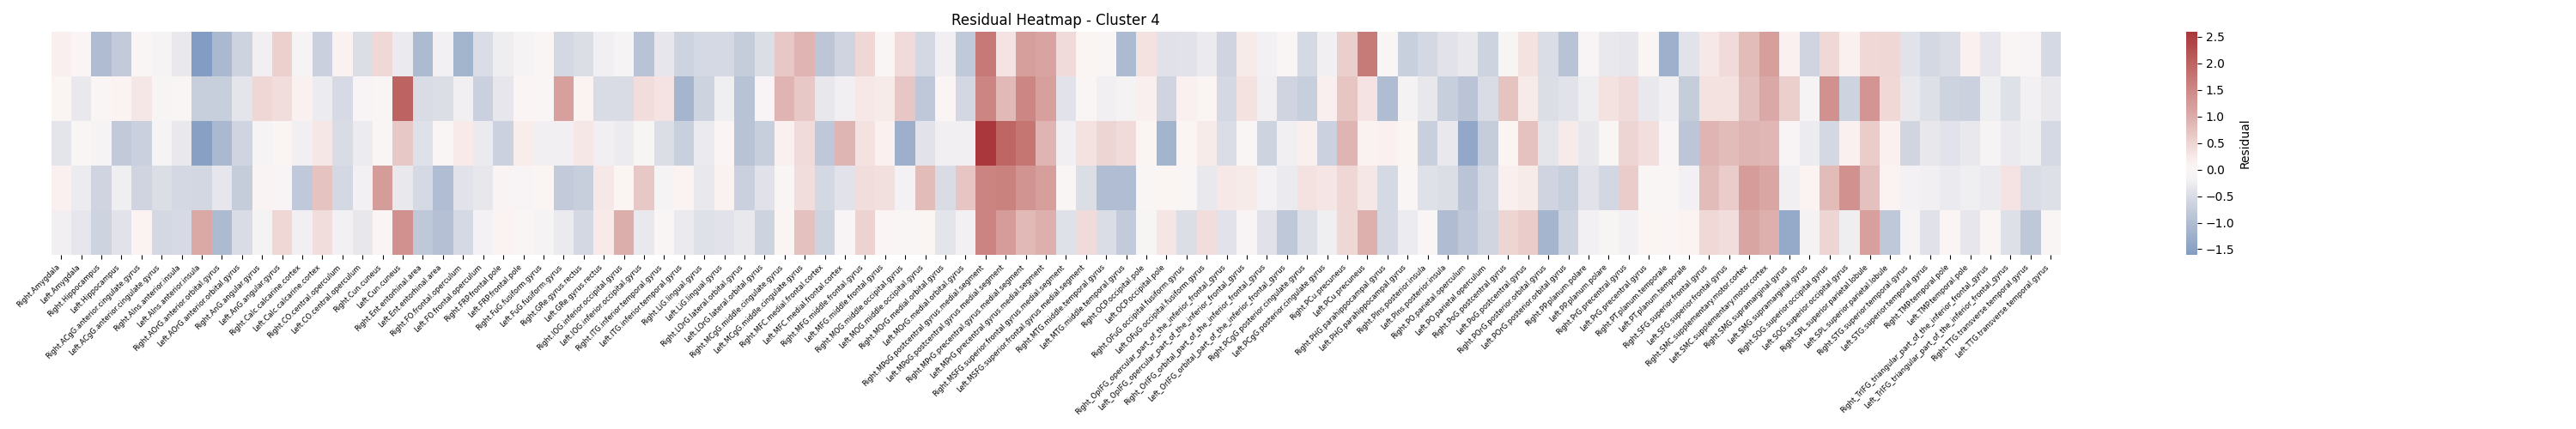

Showing Cluster 5 Heatmap:


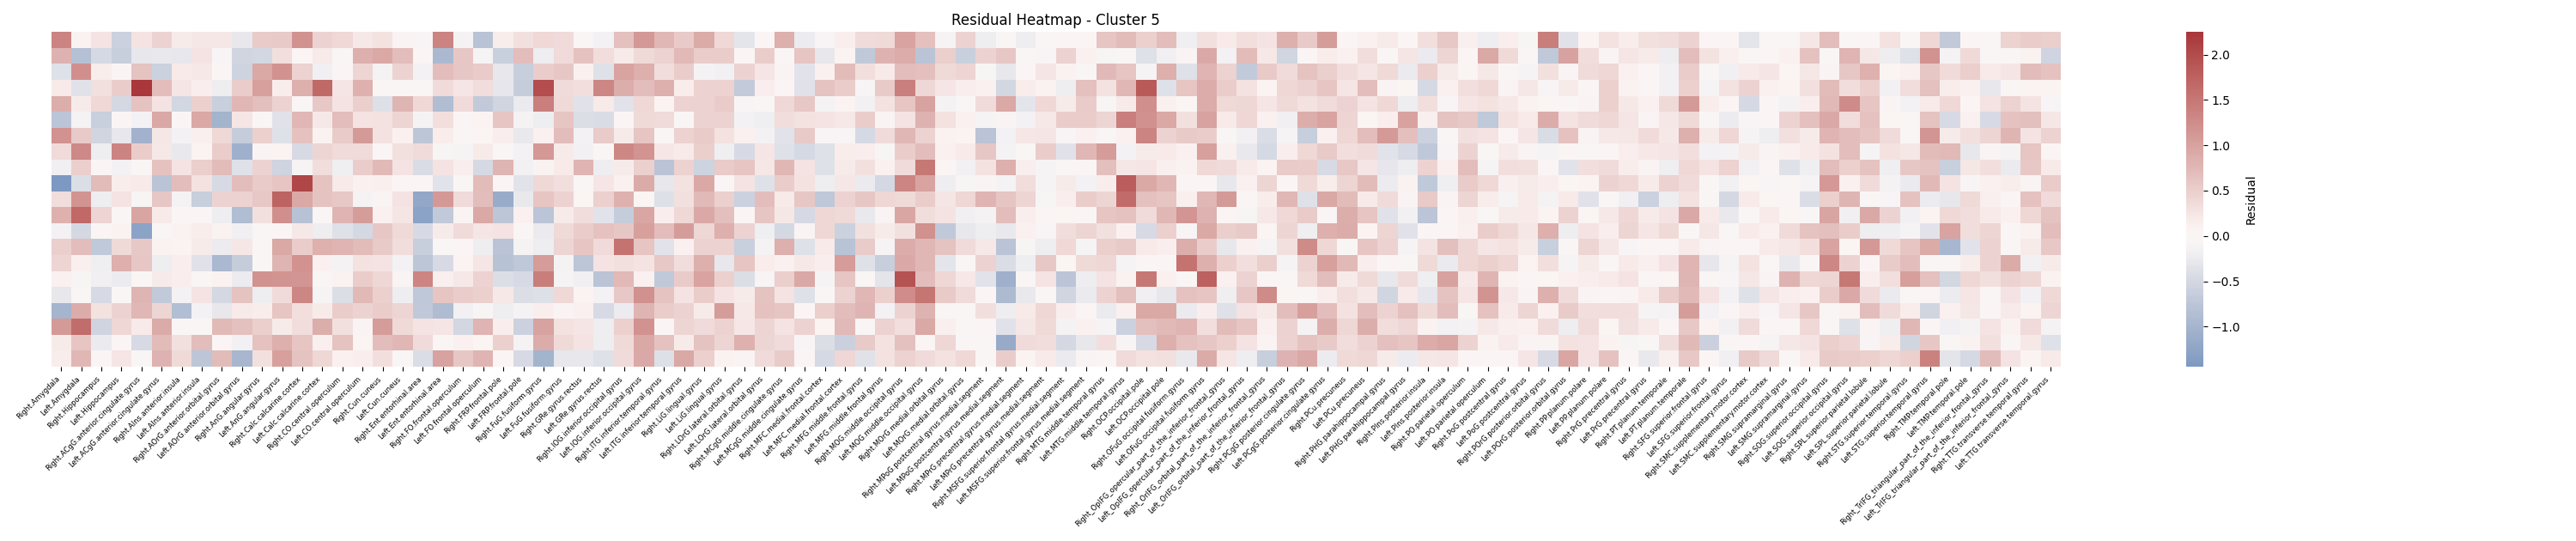

Showing Cluster 6 Heatmap:


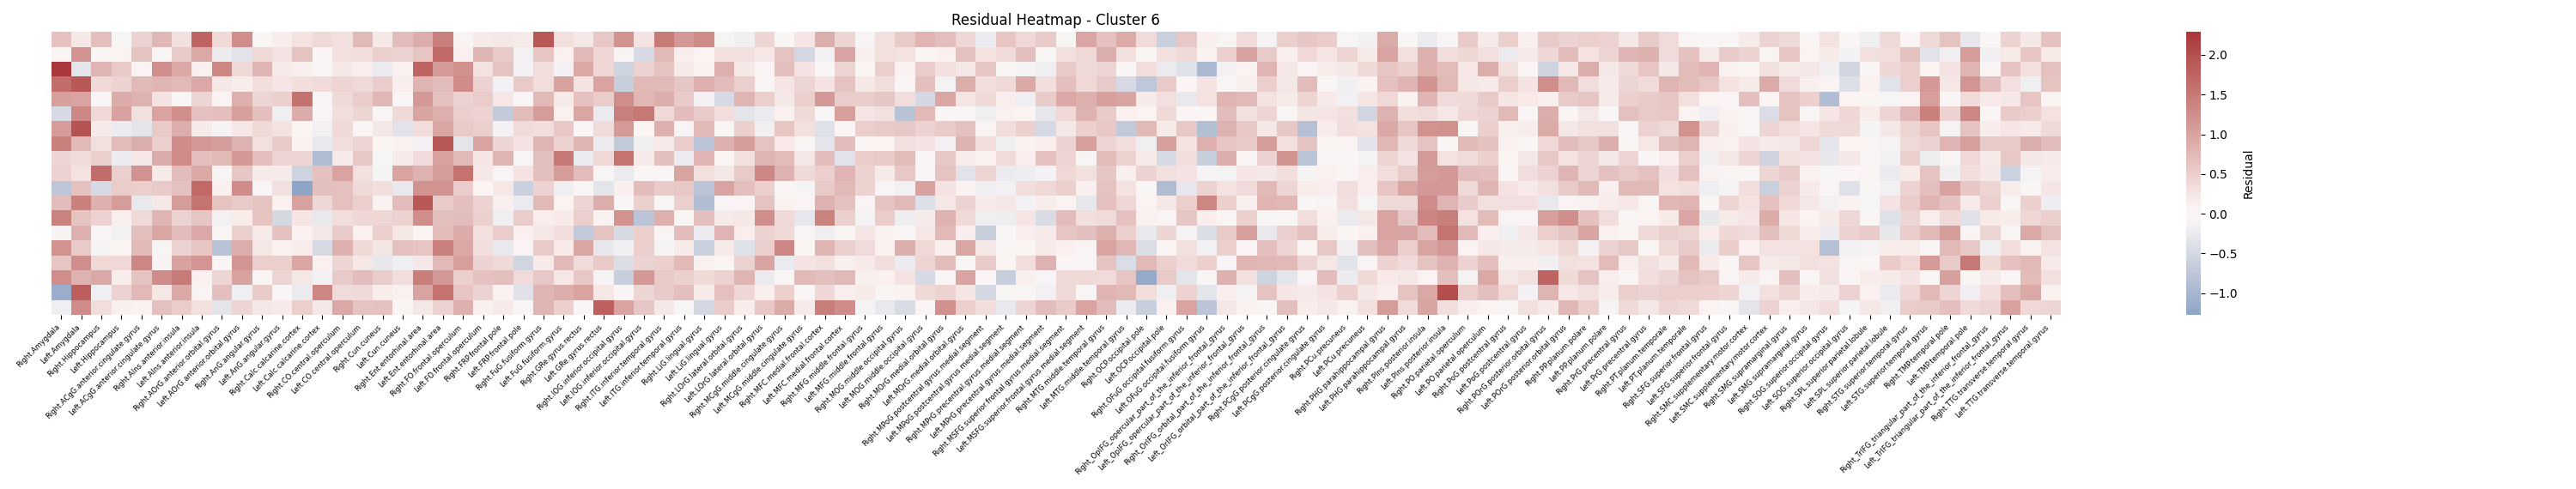

In [46]:
# residual heatmaps for each cluster

for cid, path in outputs["cluster_heatmaps"]:
    print(f"Showing Cluster {cid} Heatmap:")
    display(Image(filename=path))


### 1.3 Output 3D T-N residual maps

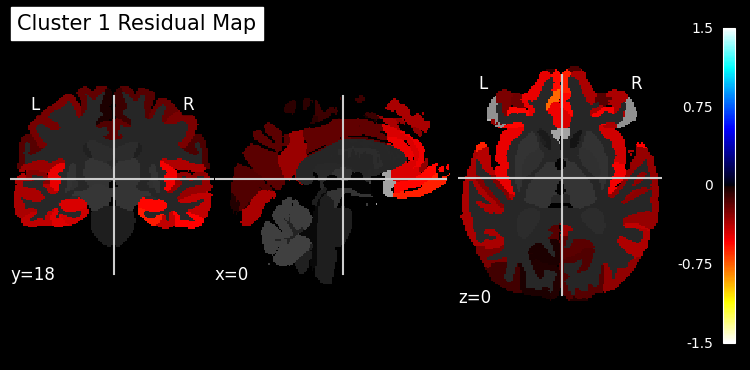

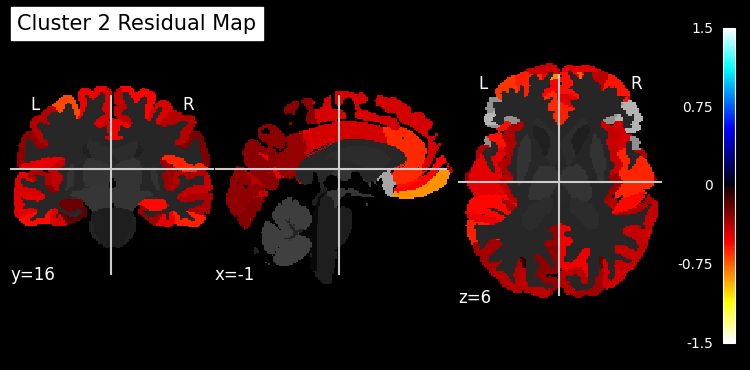

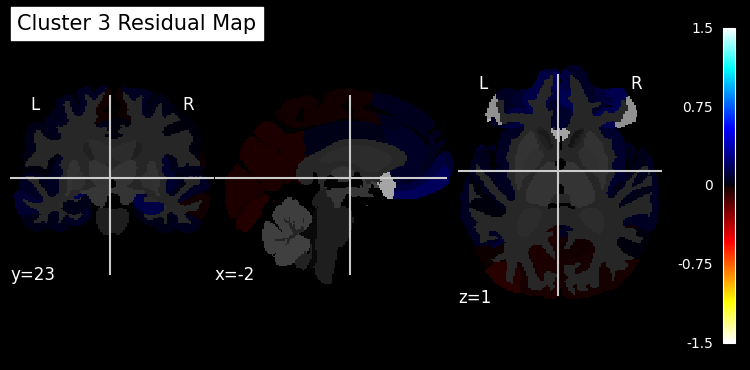

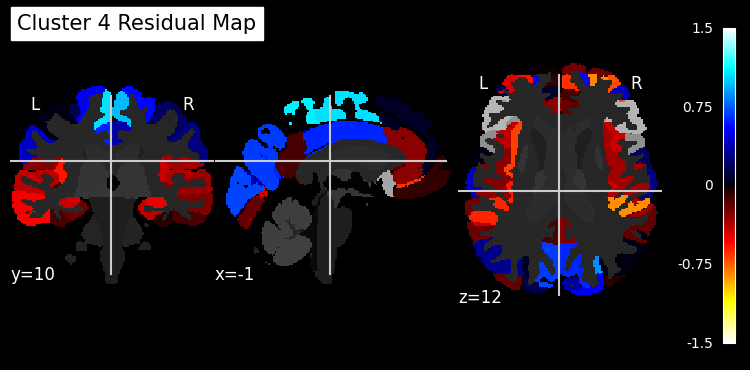

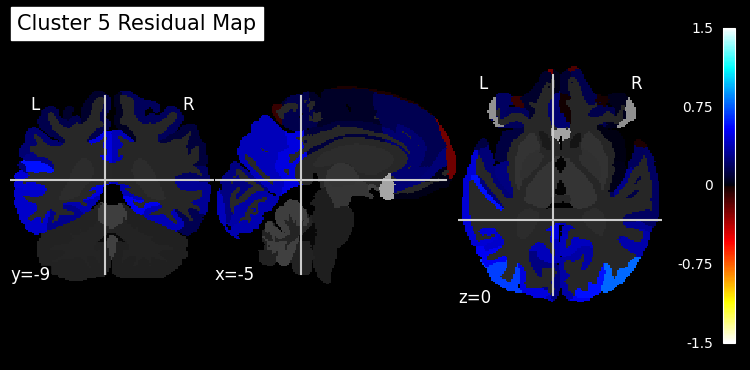

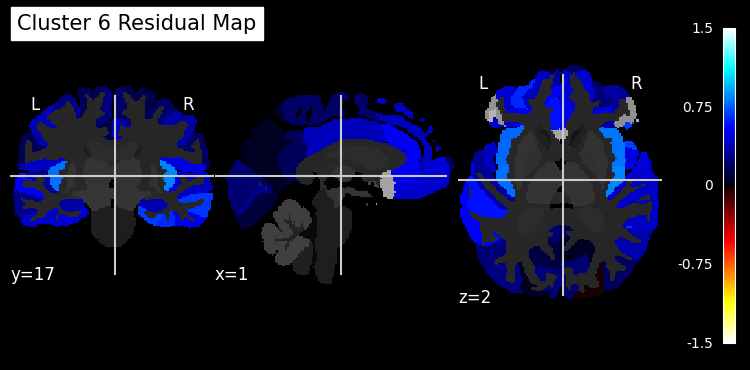

In [47]:
# Visualization of T-N residual maps 


from nilearn import plotting
import nibabel as nib
import os

# Set paths
heatmap_dir = "results/demo_run1_cluster_heatmaps"
bg_path = "./simulated_data/antsMalfLabeling.nii.gz" # Path of the customized atlas
custom_bg = nib.load(bg_path)
n_clusters=6



# Loop and display residual maps loaded on the atlas, the more negative of the residual indicates greater vulnerabilty (N>T)
for cluster_id in range(1, n_clusters + 1):    
    map_path = os.path.join(heatmap_dir, f"cluster_{cluster_id}_residual_map.nii.gz")
    
    if os.path.exists(map_path):
        stat_map = nib.load(map_path)
        title = f"Cluster {cluster_id} Residual Map"

        display = plotting.plot_stat_map(
            stat_map,
            bg_img=custom_bg,
            threshold=0,
            cmap="cold_hot_r",
            colorbar=True,
            vmin=-1.5,
            vmax=1.5,
            title=title
        )
        plotting.show()  
    else:
        print(f"⚠️ Skipped missing file: {map_path}")
        
        

# 2. Individualized MTL T-N mismatch group assignment


## 2. Assign Individuals to ADNI-Defined MTL T-N Mismatch Phenotypes

Assign individual patients to our ADNI-defined medial temporal lobe (MTL) T-N mismatch phenotypes, as described in our recent publication (Lyu et al., 2025).  
This step does **not** require re-running the clustering pipeline. Instead, it enables individual-level phenotype assignment by matching a single MRI scan and pTau217 to the trained T-N phenotypes established in the paper.


![Patient Matching](figures/Pateint_Matching.png)

---

#### 📘 Method Reference:
For detailed methodological description, please refer to our recent publication: **Lyu et al., 2025**.

#### ⚠️ Note:
This step requires prior MTL thickness preprocessing using **ASHS/CRASHS**  
→ [https://github.com/pyushkevich/crashs](https://github.com/pyushkevich/crashs)


### Step 2.1 Get super-points parcellation for MTL and compute corresponding thickness


### 2.1.1 Prepare manifest input file

In [48]:
# prepare input manifest for both left and right hemisphere, the "Path" column is the path of CRASHS generated thickness vtk

left_csv = "./simulated_data/crashs/simulated_manifest_left.csv"
pd.read_csv(left_csv).head(5)


,ID,MRIDATE,Path
0,sub1,2025-01-01,./simulated_data/crashs/sub1/crashs/crashs_lef...
1,sub2,2025-01-01,./simulated_data/crashs/sub2/crashs/crashs_lef...
2,sub3,2025-01-01,./simulated_data/crashs/sub3/crashs/crashs_lef...
3,sub4,2025-01-01,./simulated_data/crashs/sub4/crashs/crashs_lef...
4,sub5,2025-01-01,./simulated_data/crashs/sub5/crashs/crashs_lef...


### 2.1.2 Run pipeline for generating thickness for super-points

In [49]:
# === Define Inputs for Superpoint Partitioning ===

left_csv = "./simulated_data/crashs/simulated_manifest_left.csv"
right_csv = "./simulated_data/crashs/simulated_manifest_right.csv"
template_left = "./simulated_data/crashs/template_shoot_left.vtk"
template_right = "./simulated_data/crashs/template_shoot_right.vtk"
output_dir = "results/crashs_output"

# Set the number of partitions (the number of superpoints in each hemisphere)
# Use num_partitions = 50 to ensure compatibility with the MTL T-N mismatch phenotypes 
# defined in our paper (Lyu et al., 2025). 
# You may experiment with other values for exploratory or custom analyses.
num_partitions = 50

final_csv = "results/crashs_output/final_output.csv"


# Call the pipeline function for generating super-points and getting thickness value for corrsponding super-points
results = create_MTLSuperPoints(
    left_csv=left_csv,
    right_csv=right_csv,
    template_left=template_left,
    template_right=template_right,
    output_dir=output_dir,
    num_partitions=num_partitions,
    final_csv=final_csv
)



✅ VTK saved: results/crashs_output/sub1_2025-01-01_partitioned_left.vtk
✅ Mean thickness saved: results/crashs_output/mean_thickness_sub1_2025-01-01_left.txt
✅ VTK saved: results/crashs_output/sub2_2025-01-01_partitioned_left.vtk
✅ Mean thickness saved: results/crashs_output/mean_thickness_sub2_2025-01-01_left.txt
✅ VTK saved: results/crashs_output/sub3_2025-01-01_partitioned_left.vtk
✅ Mean thickness saved: results/crashs_output/mean_thickness_sub3_2025-01-01_left.txt
✅ VTK saved: results/crashs_output/sub4_2025-01-01_partitioned_left.vtk
✅ Mean thickness saved: results/crashs_output/mean_thickness_sub4_2025-01-01_left.txt
✅ VTK saved: results/crashs_output/sub5_2025-01-01_partitioned_left.vtk
✅ Mean thickness saved: results/crashs_output/mean_thickness_sub5_2025-01-01_left.txt
✅ VTK saved: results/crashs_output/sub1_2025-01-01_partitioned_right.vtk
✅ Mean thickness saved: results/crashs_output/mean_thickness_sub1_2025-01-01_right.txt
✅ VTK saved: results/crashs_output/sub2_2025-01-01

### 2.1.3 Look at Output

In [50]:
# Output of the create_MTLSuperPoints function, which is the mean thickness for every super-point
df = pd.read_csv("results/crashs_output/final_output.csv")
df.head()


,ID,MRIDATE,x_left_0,x_left_1,x_left_2,x_left_3,x_left_4,x_left_5,x_left_6,x_left_7,...,x_right_40,x_right_41,x_right_42,x_right_43,x_right_44,x_right_45,x_right_46,x_right_47,x_right_48,x_right_49
0,sub1,2025-01-01,3.2077,5.5297,6.1612,3.9837,4.0108,2.9048,3.3592,2.2733,...,2.8691,2.3884,2.5612,2.1834,2.3057,2.8176,2.1881,2.8892,2.6920,2.4409
1,sub2,2025-01-01,3.2077,5.5297,6.1612,3.9837,4.0108,2.9048,3.3592,2.2733,...,2.8691,2.3884,2.5612,2.1834,2.3057,2.8176,2.1881,2.8892,2.6920,2.4409
2,sub3,2025-01-01,4.0955,6.1148,5.9068,4.8387,4.4438,3.5203,3.2663,2.2072,...,2.8700,2.3130,2.4041,2.1343,2.2423,2.3130,2.1126,2.8506,2.2808,2.2598
3,sub4,2025-01-01,4.0955,6.1148,5.9068,4.8387,4.4438,3.5203,3.2663,2.2072,...,2.8700,2.3130,2.4041,2.1343,2.2423,2.3130,2.1126,2.8506,2.2808,2.2598
4,sub5,2025-01-01,4.2190,6.8010,7.5037,5.4314,4.5492,3.7222,3.9081,2.4254,...,3.0866,2.5549,2.5086,2.2358,2.2564,2.5226,2.4461,2.8950,2.6205,2.6165


### Step 2.2: T-N Mismatch Group Matching to Derived MTL T-N Phenotypes

The `Assigned_Cluster` column in the output CSV contains the predicted T-N mismatch group for each subject.  
Group assignment is based on the **Euclidean distance** between the subject’s residual profile and the centroids of the trained MTL T-N phenotypes described in our publication.

The output also includes each subject’s distance to every cluster centroid, providing additional information about classification confidence.


In [51]:
#The matching steps also requires bilateral amygdala volume and ICV from ASHS, and ptau217 measurement
other_biomarker = pd.read_csv("./simulated_data/crashs/simulated_biomarkers.csv")
other_biomarker.head()

,ID,x_left_Amygdala_volume,x_right_Amygdala_volume,pTau217,ICV
0,sub1,901.9392,901.9392,0.8526,1.414746e+06
1,sub2,901.9392,901.9392,0.8526,1.414746e+06
2,sub3,1181.5802,1181.5802,0.6698,1.426592e+06
3,sub4,1181.5802,1181.5802,0.6698,1.426592e+06
4,sub5,1126.3658,1126.3658,0.5510,1.412077e+06


In [52]:
# Step 2.2 MTL T-N phenotypic Matching

from mismatch.AssignGroup import AssignGroup

# Define paths
subject_path = "results/crashs_output/final_output.csv"
biomarker_path = "./simulated_data/crashs/simulated_biomarkers.csv"
output_path = "results/Assigned_TN_Phenotype.csv"


# Run the AssignGroup function
AssignGroup(
    subject_path=subject_path,
    biomarker_path=biomarker_path,
    output_path=output_path,
)


✅ Saved: results/Assigned_TN_Phenotype.csv


,ID,Assigned_Cluster,Dist_ClusterResilient,Dist_ClusterVulnerable,Dist_ClusterCanonical
0,sub1,Vulnerable,8.671619,4.898556,6.753122
1,sub2,Vulnerable,8.671619,4.898556,6.753122
2,sub3,Canonical,6.877439,8.687614,5.413059
3,sub4,Canonical,6.877439,8.687614,5.413059
4,sub5,Resilient,5.119724,9.428620,6.607037
